## Implementing a 1D convnet for sentiment analysis
  

The following uses Keras to get a baseline 1D convnet for the IMDB sentiment classification task.  It should be easy for you to improve it. 

The `Conv1D` layer  takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis.

#### Load dependencies

In [1]:
import keras
keras.__version__

from keras.datasets import imdb
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
%matplotlib inline

#### Directory to store check point files during training

In [2]:
# output directory name:
output_dir = '../weights'

#### Load data

In [3]:
n_unique_words = 150 
print('Loading data...')
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 
print(len(x_train), 'training sequences')
print(len(x_valid), 'validation sequences')

Loading data...
25000 training sequences
25000 validation sequences


#### Preprocess data

In [4]:
max_review_length = 150
pad_type = trunc_type = 'pre'
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)

x_train shape: (25000, 150)
x_valid shape: (25000, 150)


#### Design neural network architecture
You can build a convnet by  stacking of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification.



##### Baseline model


In [5]:
epochs = 10
batch_size = 128
n_embed = 100
model = Sequential()
model.add(layers.Embedding(n_unique_words, n_embed, input_length=max_review_length))
model.add(layers.Conv1D(16, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          15000     
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 16)           8016      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 23,033
Trainable params: 23,033
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Configure to store check points

In [7]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train the model
We store the history of the optimization so that we can plot it later, and choose the result from a certain good epoch.

The run time in google colab should be around 15s per epoch for the baseline model structure and hyperparameters. 

After training the model is evaluated on the validation data.

In [8]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/10
196/196 [==============================] - 2s 10ms/step - loss: 0.6214 - accuracy: 0.6591 - val_loss: 0.5763 - val_accuracy: 0.7073
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.5569 - accuracy: 0.7258 - val_loss: 0.5787 - val_accuracy: 0.6969
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.5395 - accuracy: 0.7383 - val_loss: 0.5715 - val_accuracy: 0.7295
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.5206 - accuracy: 0.7542 - val_loss: 0.5690 - val_accuracy: 0.7329
Epoch 5/10
196/196 [==============================] - 2s 8ms/step - loss: 0.5328 - accuracy: 0.7528 - val_loss: 0.6384 - val_accuracy: 0.6931
Epoch 6/10
196/196 [==============================] - 2s 8ms/step - loss: 0.6281 - accuracy: 0.7023 - val_loss: 0.6081 - val_accuracy: 0.6918
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.5522 - accuracy: 0.7300 - val_loss: 0.6039 - val_accuracy: 0.7125
Epoch

#### Display training progress

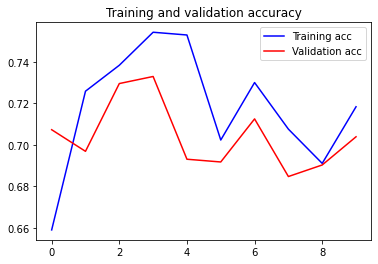

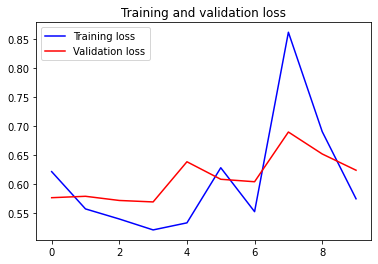

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Load the best model parameters
To do this, look at the training above and pick out the epoch that you consider to be the best. You could also attempt to identify this automatically from the history. Assuming that epoch 3 had the best results, you would load::

    model.load_weights(output_dir+"/weights.03.hdf5") # zero-indexed

In [14]:
model.load_weights(output_dir+"/weights.07.hdf5") # zero-indexed

#### Calculate the area under the curve for the ROC curve to get a scalar value to express the performance of the network
This code only runs if you ensure that the output is a probability like you would get with a sigmoid (see Jon's model)

In [15]:
y_hat = model.predict(x_valid)
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

&#39;78.81&#39;

#### Visualize the output of the classifier

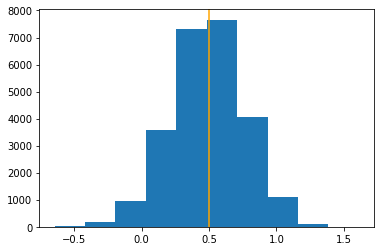

In [10]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

## 1D and 2D convnets

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. 
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.